![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

import re

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = DATA_DIR = './'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.3+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

В датасете три количественных признака:
* **Ranking**

* **Rating**

* **Number of Reviews**

Семь номинативных признаков:
* **Price Range**

* **City**

* **Cuisine Style**

* **Reviews**

* **Restaurant_id**

* **ID_TA**

* **URL_TA**

Причем последние три признака можно отнести к "техническим", для построения модели их вряд ли нужно будет использовать.


In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
15965,id_1743,Budapest,"['European', 'Street Food', 'Hungarian']",1744.0,$,16.0,"[['Yummy Street Food', 'I absolutely love Kolb...",/Restaurant_Review-g274887-d8669514-Reviews-Re...,d8669514,1,4.0
16695,id_1227,London,"['Bar', 'European', 'British', 'Pub', 'Interna...",1229.0,$$ - $$$,297.0,"[['Nice place, good food, beautiful atmospher....",/Restaurant_Review-g186338-d730419-Reviews-Abi...,d730419,1,4.5
36128,id_5150,London,"['American', 'Pizza', 'Fast Food', 'Vegetarian...",5159.0,$,241.0,"[['Great food but under staffed.', 'Much neede...",/Restaurant_Review-g186338-d3437604-Reviews-Pi...,d3437604,1,3.5
7400,id_7400,Madrid,"['Delicatessen', 'Healthy', 'European', 'Veget...",175.0,$$ - $$$,151.0,"[['Wonderful', 'Excellent restaurant'], ['12/1...",/Restaurant_Review-g187514-d10451094-Reviews-L...,d10451094,0,0.0
8812,id_8812,Paris,['Japanese'],10791.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d7059528-Reviews-Da...,d7059528,0,0.0


In [14]:
# Посмотрим внимательнее на сложные признаки
data['Cuisine Style'][1]

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

In [15]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [16]:
data['URL_TA'][1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [17]:
# Посмотрим количество пропусков в каждом признаке и какой процент от всего датасета они занимают.
nan_df = pd.DataFrame(data.isna().sum(), columns=['Количество'])

nan_df['%'] = nan_df['Количество'].apply(lambda x: round((x/len(data))*100, 0))
print(nan_df)

                   Количество     %
Restaurant_id               0   0.0
City                        0   0.0
Cuisine Style           11590  23.0
Ranking                     0   0.0
Price Range             17361  35.0
Number of Reviews        3200   6.0
Reviews                     2   0.0
URL_TA                      0   0.0
ID_TA                       0   0.0
sample                      0   0.0
Rating                      0   0.0


Шесть из десяти колонок не имеют пропусков, в т.ч. целевая переменная - Rating.
Колонки с пропущенными значениями:

*Cuisine style*

*Price range*

*Number of Reviews*

*Reviews*

In [18]:
# Вынесем наличие пропусков в указанных колонках (кроме Reviews) в отдельные признаки.
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')
data['Cuisine_style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price_range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

## 2. Обработка числовых признаков


In [19]:
data.describe()

,Ranking,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Cuisine_style_isNAN,Price_range_isNAN
count,50000.000000,46800.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430,0.064000,0.231800,0.347220
std,3700.092452,294.114345,0.400004,1.705453,0.244755,0.421986,0.476091
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000,0.000000,0.000000,0.000000
50%,2278.000000,33.000000,1.000000,4.000000,0.000000,0.000000,0.000000
75%,5241.000000,115.000000,1.000000,4.500000,0.000000,0.000000,1.000000
max,16444.000000,9660.000000,1.000000,5.000000,1.000000,1.000000,1.000000


### Посмотрим распределение целевой переменной

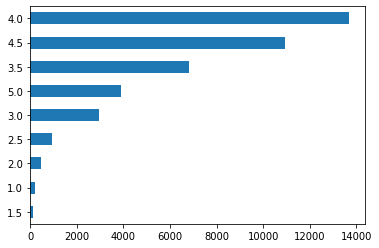

In [20]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### 2.1. Number of Reviews

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Количество отзывов')

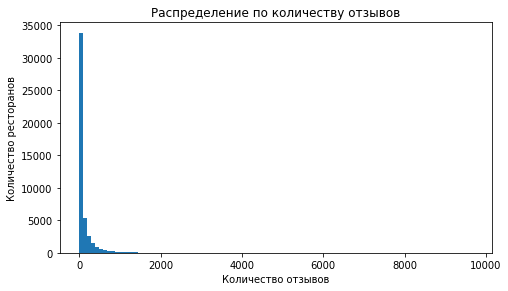

In [21]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 0.8])
axes.hist(data['Number of Reviews'], bins=100)
axes.set_title('Распределение по количеству отзывов')
axes.set_ylabel('Количество ресторанов')
axes.set_xlabel('Количество отзывов')

In [22]:
# Заполняем пропуски в колонке средним количеством отзывов в зависимости от города
data['Number of Reviews'] = data.groupby('City')['Number of Reviews'].transform(
    lambda x: x.fillna(round(x.mean(), 0)))

### 2.2.  Ranking

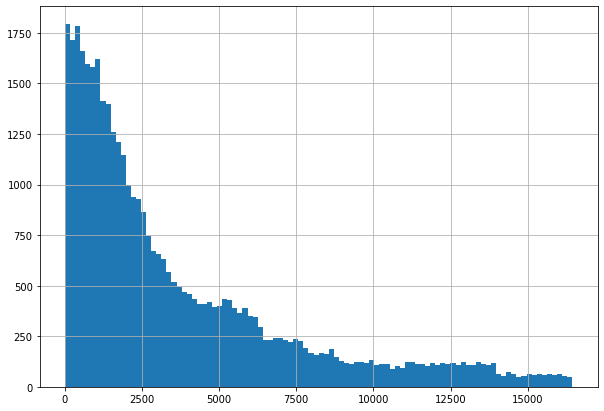

In [23]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

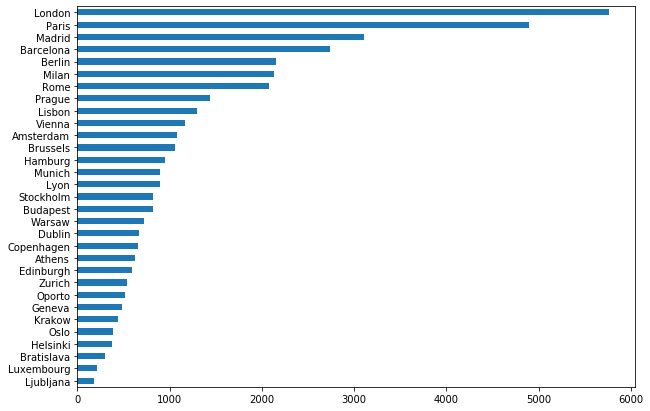

In [24]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

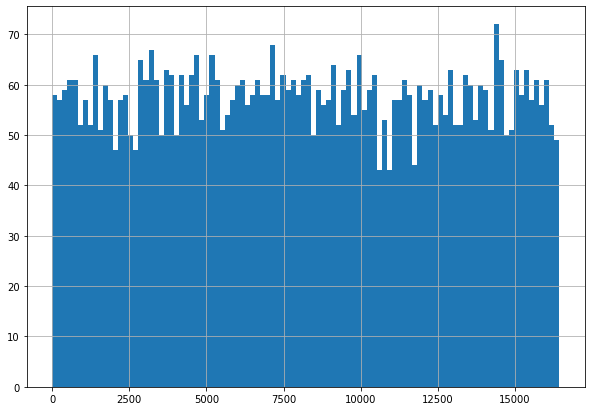

In [25]:
df_train['Ranking'][df_train['City'] == 'London'].hist(bins=100)

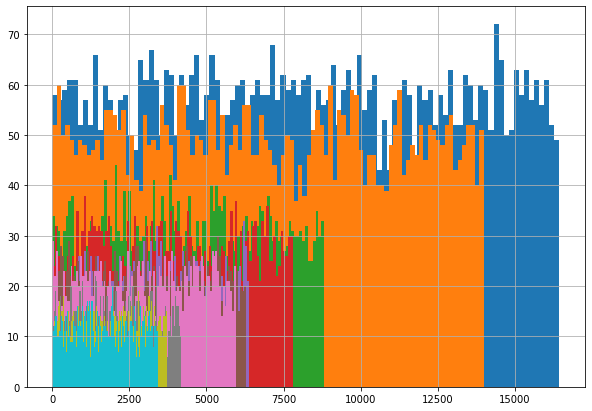

In [26]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [27]:
# нормализуем признак Ranking в пределах каждого города
means = data.groupby('City')['Ranking'].mean()
std = data.groupby('City')['Ranking'].std()
data['Ranking'] = (data.Ranking - data.City.map(means))/(data.City.map(std))

## 3. Номинативные признаки

### 3.1. City

In [28]:
# Загружаем дополнительный датасет для обработки колонки.

df_cities = pd.read_csv(DATA_DIR+'worldcities.csv')

In [29]:
# Приводим назвние 'Porto' к тому, что используется в датасете data - 'Oporto'
df_cities['city_ascii'] = df_cities.city_ascii.apply(
    lambda x: 'Oporto' if x == 'Porto' else x)

### 3.1.1. Country

In [30]:
# создадим словарь из датасета df_cities, где ключ - город, значение - страна.
df_cities_1 = df_cities.drop(
    ['city', 'lat', 'lng', 'iso2', 'iso3', 'admin_name', 'capital', 'population', 'id'], axis=1)
df_countries = df_cities_1[(df_cities_1['country'] != 'United States') & (
    df_cities_1['country'] != 'Canada') & (df_cities_1['country'] != 'Venezuela')]
df_countries.set_index("city_ascii", drop=True, inplace=True)
country_dict = df_countries.to_dict()
country_dict_n = country_dict['country']

In [31]:
# Добавим новый признак - страна
data['Country'] = data['City'].apply(lambda x: country_dict_n[x])

### 3.1.2. Population

In [32]:
# создадим словарь из датасета df_cities, где ключ - город, значение - размер населения
df_population = df_cities[(df_cities['country'] != 'United States') & (
    df_cities['country'] != 'Canada')]
df_population = df_population.drop(
    ['city', 'lat', 'lng', 'iso2', 'iso3', 'admin_name', 'capital', 'country', 'id'], axis=1)

df_population.set_index("city_ascii", drop=True, inplace=True)
population_dict = df_population.to_dict()
population_dict_n = population_dict['population']

In [33]:
# Дополним датасет признаком - население города
data['Population'] = data['City'].apply(lambda x: population_dict_n[x])

### 3.1.3. Capitals

In [34]:
# создаем множество из названий столиц из датасета df_cities
capitals = set(df_cities[df_cities['capital'] == 'primary']['city_ascii'])

In [35]:
# Функция для определения статуса города: столица или нет
def capital_check(city):
    if city in capitals:
        return 'capital' 
    return 'non_capital'

In [36]:
# Дополним датасет колонками, определяющими является город столицей или нет.
data['Сity_status'] = data['City'].apply(capital_check)

### 3.1.4. Tourists 

In [37]:
# Добавим словарь с количеством туристов в каждом городе. Нужного датасета не нашлось, данные берем из отчета за 2018 год Euripean Cities Marketing, сайта statista.com и Википедии
tourists_dict = {
    'London': 71.16,
    'Paris': 52.56,
    'Madrid': 19.83,
    'Barcelona': 19.29,
    'Berlin': 32.87,
    'Milan': 12.29,
    'Rome': 28.55,
    'Prague': 18.25,
    'Lisbon': 10.76,
    'Vienna': 17.41,
    'Amsterdam': 16.94,
    'Brussels': 3.91,
    'Hamburg': 14.53,
    'Munich': 17.12,
    'Lyon': 3.5,
    'Stockholm': 14.59,
    'Warsaw': 3.0,
    'Budapest' :12.5,
    'Dublin': 11.2,
    'Copenhagen': 5.9,
    'Athens': 5.7,
    'Edinburgh' :3.85,
    'Zurich': 4.2,
    'Oporto': 1.6,
    'Geneva': 2.6,
    'Krakow': 3.3,
    'Oslo': 3.6,
    'Helsinki': 1.2,
    'Bratislava': 0.88,
    'Luxembourg': 1.1,
    'Ljubljana': 0.39
}

In [38]:
# Добавим колонку с количеством иностранных туристов в каждом городе

data['tourists_qnt'] = data['City'].apply(lambda x: tourists_dict[x])

### 3.2. Cuisine_style

Определим самые популярные типы кухни

In [39]:
# Приводим строковые значения типов кухни к спискам
data['Cuisine Style'] = data['Cuisine Style'].astype(str).apply(
    lambda x: str(x).replace('[', '').replace(']', '').replace("'", "").strip())

data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x:  None if x == 'nan' else [
    info.strip() for info in str(x).split(',')])

In [40]:
# Создаем список из 10 самых популярных типов кухни
cuisine_list = pd.DataFrame(data['Cuisine Style'].dropna(
).tolist()).stack().value_counts().reset_index()
top_cuisine = cuisine_list['index'][:10].tolist()

In [41]:
# Заменяем отсутствующие значения в колонке на 'not_define'
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: 'not_define' if x == None else x)

### 3.2.1. Cuisine quantity[](http://)

In [42]:
# Дополняем датасет новым признаком 'cuisine_qnt' - количество типов кухни в каждом ресторане
data['cuisine_qnt'] = data['Cuisine Style'].apply(lambda x: len(x))

In [43]:
# Оставляем только самые популярные кухни, остальные заменим на 'other'
def check_cousine(raw):
    line = []
    top_list = ['Vegetarian Friendly', 'European', 'Mediterranean',
                'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian']
    for item in raw:
        if item.strip() == 'not_define':
            line.append('not_define')
        elif item.strip() in top_cuisine:
            line.append(item.strip())
        else:
            line.append('other_cuisine')
    return line


data['Cuisine Style'] = data['Cuisine Style'].apply(check_cousine)

In [44]:
# Дополняем датасет колонками с типом кухни
mlb = MultiLabelBinarizer()

data = data.join(pd.DataFrame(mlb.fit_transform(
    data.pop('Cuisine Style')), index=data.index, columns=mlb.classes_))

### 3.3. Price Range

In [45]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [46]:
# Заменяем пропуски в 'Price Range' наиболее часто встречающейся категорией
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

In [47]:
# Переводим значения из номинативного признака в ординарный с помощью словаря
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)

### 3.4. Review

In [48]:
data['Reviews'].value_counts()

[[], []]                                                                                                                              8112
[['Very cozy!', 'Service rate: 1'], ['01/17/2016', '11/18/2015']]                                                                        2
[['Enjoyable restaurant with indoor and outdo...', 'Delicious food'], ['11/04/2017', '10/31/2017']]                                      2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]                                           2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                                         2
[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]                                           2
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                                                 2
[['Sat night', 'Can\'t even

Пропущенных значений всего 2, но фактически пустых значений  гораздо больше, т.к. в 8112 строках указано '[[], []]' Заменим их на None и вынесем отсутствие отзывов в отдельный признак.

In [49]:
data['Reviews'] = data.Reviews.apply(lambda x: None if x == '[[], []]' else x)
data['Review_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

In [50]:
# Разобьем на два признака: содержащий отзывы и содержащий даты.
data[['reviews_text', 'reviews_date']
     ] = data['Reviews'].str.split("'],", expand=True)

### 3.4.1. Reviews_date

In [51]:
# выделим даты
data['reviews_date'] = data.reviews_date.dropna().astype(str).apply(
    lambda x: None if pd.isnull(x) else re.compile('\d*/\d*/\d*').findall(x))

In [52]:
# функция для формирования списка из дат в нужном формате
def to_time(line):
    line = [pd.to_datetime(item) for item in line]
    return line


data['reviews_date'] = data.reviews_date.dropna().apply(to_time)

In [53]:
# функция для вычисления количество дней прошедших между первым и вторым отзывом
def find_delta(line):
    return (max(line) - min(line))


data['delta_reviews_date'] = data['reviews_date'].dropna().apply(find_delta).dt.days

In [54]:
# Заполним пропуски 0
data['delta_reviews_date'] = data['delta_reviews_date'].fillna(0)

### 3.4.2.  Reviews_text

In [55]:
# приведем все буквы к нижнему регистру
data['reviews_text'] = data.reviews_text.apply(
    lambda x: x if pd.isnull(x) else x.lower())

In [56]:
# Выделим из текста слова состоящие более чем из двух букв
data['reviews_text_1'] = data.reviews_text.astype(str).apply(
    lambda x: re.compile('[a-z][a-z]\w+').findall(x))

In [57]:
# Посмотрим какие слова в отзывах встречаются чаще всего
word_list = pd.DataFrame(data.reviews_text_1.dropna(
).tolist()).stack().value_counts().reset_index()
word_list[:40]

,index,0
0,food,13166
1,good,11780
2,great,10628
3,and,9765
4,one,8755
5,the,6186
6,nice,5702
7,place,5166
8,for,4803
9,service,4383


In [58]:
# Создадим список из наиболее часто встречающихся прилагательных, описывающих впечатление.  Также добавим в список частицу "not"
words_list = ['not', 'good', 'nice', 'great', 'very', 'best', 'excellent',
              'delicious', 'friendly', 'lovely', 'amazing', 'tasty', 'fantastic', 'average']

In [59]:
# Функция, которая оставляет в отзывах только наиболее часто встречающиеся слова
def check_words(raw):
    line = []
    for item in raw:
        if item in words_list:
            line.append(item)
        else:
            continue
    return line


data['reviews_text_1'] = data['reviews_text_1'].apply(check_words)

In [60]:
# Используем функцию для получения "One-Hot-Encoded" из списка.
mlb = MultiLabelBinarizer()

data = data.join(pd.DataFrame(mlb.fit_transform(
    data.pop('reviews_text_1')), index=data.index, columns=mlb.classes_))

In [61]:
# Для кодирования оставшихся категориальных признаков через подход One-Hot Encoding используем функцию get_dummies
data = pd.get_dummies(data, columns=['City', 'Country', 'Сity_status'])

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 99 columns):
Restaurant_id              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
Reviews                    41886 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_style_isNAN        50000 non-null uint8
Price_range_isNAN          50000 non-null uint8
Population                 50000 non-null float64
tourists_qnt               50000 non-null float64
cuisine_qnt                50000 non-null int64
Asian                      50000 non-null int64
Bar                        50000 non-null int64
European                   50000 non-null int64
French       

## Корреляция признаков

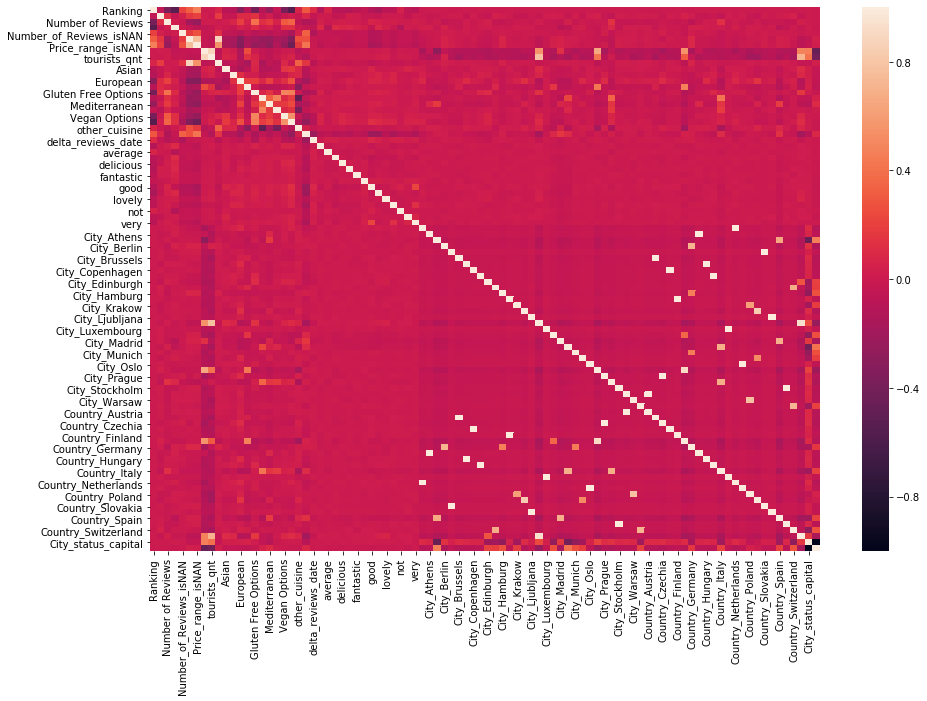

In [63]:
data_corr = data[data['sample'] == 1]
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_corr.drop('sample', axis=1).corr())

## Data Preprocessing¶


In [64]:
# Удаляем оставшиеся номинативные признаки
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 93 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Cuisine_style_isNAN        50000 non-null uint8
Price_range_isNAN          50000 non-null uint8
Population                 50000 non-null float64
tourists_qnt               50000 non-null float64
cuisine_qnt                50000 non-null int64
Asian                      50000 non-null int64
Bar                        50000 non-null int64
European                   50000 non-null int64
French                     50000 non-null int64
Gluten Free Options        50000 non-null int64
Italian                    50000 non-null int64
Mediterranean              50000 non-null int64
Pizza            

In [66]:
# Нормализуем все данные кроме 'Rating','sample', 'Ranking'. Последний был нормализован ранее относительно городов.
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])


for i in list(data.columns):
    if i not in ['Rating', 'sample', 'Ranking']:
        data[i] = StandardScaler_column(i)
        if len(data[data[i].isna()]) < len(data):
            data[i] = data[i].fillna(0)

#### Запускаем и проверяем что получилось

In [67]:
df_preproc = data

df_preproc.head(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Cuisine_style_isNAN,Price_range_isNAN,Population,tourists_qnt,cuisine_qnt,Asian,Bar,European,French,Gluten Free Options,Italian,Mediterranean,Pizza,Vegan Options,Vegetarian Friendly,other_cuisine,Review_isNAN,delta_reviews_date,amazing,...,City_Zurich,Country_Austria,Country_Belgium,Country_Czechia,Country_Denmark,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Ireland,Country_Italy,Country_Luxembourg,Country_Netherlands,Country_Norway,Country_Poland,Country_Portugal,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,Сity_status_capital,Сity_status_non_capital
0,1.491224,0.286525,-0.420621,0,0.0,-0.261488,-0.549313,-0.729321,1.742102,1.088726,-0.818705,-0.286222,3.348581,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,2.272045,-0.508835,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,2.431420,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
1,-1.404530,0.286525,-0.094046,0,0.0,-0.261488,-0.549313,-0.729321,-0.882033,-1.147007,0.087102,-0.286222,-0.298634,1.726434,-0.293680,2.939932,-0.417874,-0.430576,-0.274436,2.792243,1.601899,0.472104,-0.440132,-0.321521,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,10.210933,-0.411282,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
2,-0.146058,0.286525,-0.336344,0,0.0,-0.261488,-0.549313,-0.729321,-1.064171,-1.031651,-1.120641,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,1.601899,-2.118175,-0.440132,-0.397459,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,2.301916,-1.708181,1.708181
3,-1.376113,2.660782,0.274667,0,0.0,-0.261488,-0.549313,-0.729321,1.342913,1.898396,0.087102,-0.286222,-0.298634,1.726434,-0.293680,2.939932,2.393065,2.322469,-0.274436,-0.358135,1.601899,-2.118175,-0.440132,-0.437959,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,2.301916,0.585418,-0.585418
4,-1.673120,2.660782,0.134205,0,0.0,-0.261488,-0.549313,-0.729321,-1.088424,-1.160937,0.389038,-0.286222,-0.298634,1.726434,-0.293680,2.939932,2.393065,2.322469,-0.274436,-0.358135,1.601899,0.472104,-0.440132,-0.432897,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,11.427115,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
5,-0.456829,-2.087731,-0.350390,0,0.0,-0.261488,-0.549313,-0.729321,1.742102,1.088726,-0.516769,-0.286222,-0.298634,-0.579229,3.405064,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,-0.440132,-0.483522,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,2.431420,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
6,1.715451,-2.087731,-0.427644,0,0.0,-0.261488,-0.549313,-0.729321,-0.375359,-0.730854,-0.818705,-0.286222,-0.298634,1.726434,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,2.272045,-0.508835,-0.187494,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.144380,-0.130401,-0.343719,-0.07271

In [68]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 93 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null float64
Cuisine_style_isNAN        50000 non-null float64
Price_range_isNAN          50000 non-null float64
Population                 50000 non-null float64
tourists_qnt               50000 non-null float64
cuisine_qnt                50000 non-null float64
Asian                      50000 non-null float64
Bar                        50000 non-null float64
European                   50000 non-null float64
French                     50000 non-null float64
Gluten Free Options        50000 non-null float64
Italian                    50000 non-null float64
Mediterranean              50000 non-null f

In [69]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [70]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [71]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 92), (40000, 92), (40000, 91), (32000, 91), (8000, 91))

# Model 
Сам ML

In [72]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [73]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [74]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [75]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.203293125


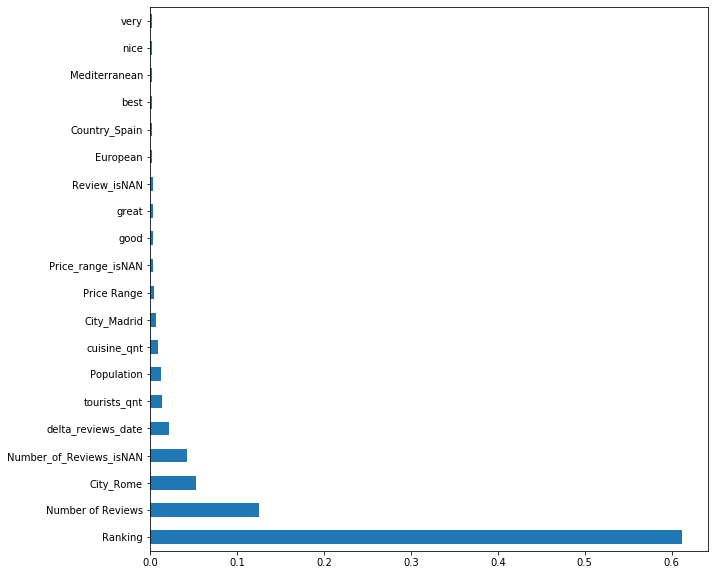

In [76]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [77]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_style_isNAN,Price_range_isNAN,Population,tourists_qnt,cuisine_qnt,Asian,Bar,European,French,Gluten Free Options,Italian,Mediterranean,Pizza,Vegan Options,Vegetarian Friendly,other_cuisine,Review_isNAN,delta_reviews_date,amazing,average,...,City_Zurich,Country_Austria,Country_Belgium,Country_Czechia,Country_Denmark,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Ireland,Country_Italy,Country_Luxembourg,Country_Netherlands,Country_Norway,Country_Poland,Country_Portugal,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,Сity_status_capital,Сity_status_non_capital
3286,1.482885,-2.087731,0.141228,0.0,-0.261488,-0.549313,-0.729321,-0.375359,-0.730854,-1.120641,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,-0.440132,-0.483522,-0.187494,-0.135388,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.14438,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,4.565479,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
9946,-0.472896,2.660782,-0.403063,0.0,-0.261488,-0.549313,-0.729321,-0.890990,-0.942413,-0.818705,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,-0.440132,-0.508835,-0.187494,-0.135388,...,-0.117857,-0.172388,-0.164284,-0.194136,7.749197,-0.097934,-0.411282,-0.334665,-0.125557,-0.14438,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
7167,0.547734,0.286525,-0.083512,0.0,3.824265,1.820457,1.371138,0.447202,-0.336031,1.596781,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,2.272045,-0.508835,-0.187494,-0.135388,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.14438,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,2.436542,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
2186,0.938127,0.286525,-0.378482,0.0,-0.261488,1.820457,1.371138,-0.815751,-1.129595,1.596781,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,-0.440132,5.525721,-0.187494,-0.135388,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.14438,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,4.565479,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,-1.708181,1.708181
341,-0.745447,-2.087731,-0.357413,0.0,-0.261488,-0.549313,-0.729321,1.742102,1.088726,-1.120641,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,-0.417874,-0.430576,-0.274436,-0.358135,-0.624259,0.472104,-0.440132,-0.483522,5.333517,-0.135388,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.097934,2.431420,-0.334665,-0.125557,-0.14438,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
8680,1.337638,0.286525,0.000766,0.0,3.824265,-0.549313,1.371138,-0.868000,-0.404810,-1.120641,-0.286222,-0.298634,-0.579229,-0.293680,-0.340144,2.393065,-0.430576,-0.274436,-0.358135,-0.624259,-2.118175,2.272045,-0.508835,-0.187494,-0.135388,...,-0.117857,-0.172388,-0.164284,5.151023,-0.129046,-0.097934,-0.411282,-0.334665,-0.125557,-0.14438,-0.130401,-0.343719,-0.072717,-0.167971,-0.099278,-0.17459,-0.219035,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763,-0.434421,0.585418,-0.585418
548,-1.546933,0.286525,0.049928,0.0,-0.261488,-0.549313,-0.729321,-0.837546,-0.564132,0.389038,-0.286222,-0.298634,1.726434,-0.293680,2.939932,-0.417874,-0.430576,-0.274436,2.792243,1.601899,0.472104,-0.440132,-0.503772,-0.187494,-0.135388,...,-0.117857,-0.172388,-0.164284,-0.194136,-0.129046,-0.0979

In [78]:
test_data = test_data.drop(['Rating'], axis=1)

In [79]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
5,id_5,4.5
6,id_6,4.5
7,id_7,2.0
8,id_8,2.0
9,id_9,3.5


In [80]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [81]:
predict_submission

array([3.155, 4.27 , 4.42 , ..., 3.17 , 4.41 , 4.25 ])

In [82]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.155
1,id_1,4.270
2,id_2,4.420
3,id_3,4.370
4,id_4,4.410
5,id_5,4.370
6,id_6,3.010
7,id_7,3.155
8,id_8,4.155
9,id_9,4.610
